# Big Data Hypotesis 5: Are spoiler reviews considered less helpful by the users?

In [1]:
import findspark
# Locate the Spark installation 
findspark.init()

import pyspark
from pyspark import StorageLevel
from pyspark.sql.functions import regexp_replace
from pyspark.sql import *

spark = SparkSession.builder\
        .appName("H1")\
        .master("local[*]")\
        .config("spark.driver.memory", "4g")\
        .config("spark.executor.memory", "5g")\
        .config("spark.storage.memoryFraction", "0.5")\
        .config("spark.shuffle.memoryFraction", "0.5")\
        .config("spark.driver.maxResultSize", "0")\
        .getOrCreate()

23/06/27 18:29:25 WARN Utils: Your hostname, DSaDBA resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/06/27 18:29:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/27 18:29:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#Importing Needed Libraries 
from pyspark.sql.functions import col, sum, count, when
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import t
import numpy as np
import pandas as pd

In [3]:
from pyspark.sql.types import StructType, StructField, ArrayType, StringType, LongType

# Define the schema
schema = StructType([
    StructField('movie', StringType(), True),
    StructField('rating', LongType(), True),
    StructField('genre', StringType(), True),
    StructField('review_date', StringType(),True),
    StructField('review_detail', StringType(), True),
    StructField('review_id', StringType(), True),
    StructField('review_summary', StringType(), True),
    StructField('reviewer', StringType(), True),
    StructField('spoiler_tag', LongType(), True),
    StructField('helpful_upvotes', LongType(), True),
    StructField('helpful_total', LongType(), True)])

In [4]:
# Limit the size of the data to around 1GB due to working on a single machine
lim = 1000000


# Read the files to filter from the HDFS and display the table
columns = ['movie', 'spoiler_tag', 'review_detail', 'helpful_upvotes', 'helpful_total']
base_df = spark.read.csv('hdfs://localhost:54310/user/data/filtered', schema=schema, sep="\t", mode="DROPMALFORMED").select(columns)
df = base_df.sample(withReplacement=False, fraction=lim/base_df.count())
#Preparing Data To Ivestigate The Hypothesis
df.limit(5).toPandas()

,movie,spoiler_tag,review_detail,helpful_upvotes,helpful_total
0,Satanic (2016),1,The only two things that stopped me from givin...,6,12
1,Satanic (2016),0,Who knew that worshiping the Devil would be th...,3,6
2,Satanic (2016),0,"First of all, I watch movies for fun, and this...",9,20
3,Satanic (2016),0,"Seriously, don't waste yout time, this is a pr...",1,3
4,Satanic (2016),0,"Awful plot, awful dialogue, and silly special ...",1,4


In [6]:
# Compute helpfulness proportions
df = df.withColumn('helpfulness_prop', col('helpful_upvotes') / col('helpful_total'))

# Calculate summary statistics
num_spoiler_reviews = df.filter(col('spoiler_tag') == 1).count()
num_no_spoiler_reviews = df.filter(col('spoiler_tag') == 0).count()

print('Spoiler reviews:', num_spoiler_reviews)
print('No spoiler reviews:', num_no_spoiler_reviews)

# Calculate total helpfulness proportions
total_helpfulness = df.groupBy().agg(sum('helpfulness_prop')).collect()[0][0]
sum_helpfulness_spoiler = df.filter(col('spoiler_tag') == 1).groupBy().agg(sum('helpfulness_prop')).collect()[0][0]
sum_helpfulness_NO_spoiler = df.filter(col('spoiler_tag') == 0).groupBy().agg(sum('helpfulness_prop')).collect()[0][0]

# Calculate percentage of helpfulness_prop
percentage_spoiler = (sum_helpfulness_spoiler / total_helpfulness) * 100
percentage_NO_spoiler = (sum_helpfulness_NO_spoiler / total_helpfulness) * 100

print("Percentage of helpfulness_prop for reviews with spoilers: %.2f%%" % percentage_spoiler)
print("Percentage of helpfulness_prop for reviews with NO spoilers: %.2f%%" % percentage_NO_spoiler)

Spoiler reviews: 219671
No spoiler reviews: 782270


Percentage of helpfulness_prop for reviews with spoilers: 21.88%
Percentage of helpfulness_prop for reviews with NO spoilers: 78.12%


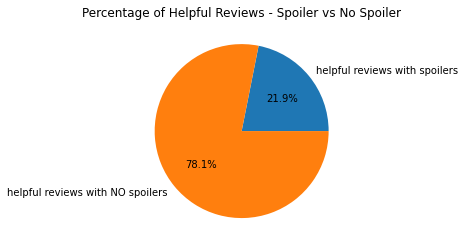

In [7]:
# Pie chart
percentages = [percentage_spoiler, percentage_NO_spoiler]
labels = ['helpful reviews with spoilers', 'helpful reviews with NO spoilers']
plt.pie(percentages, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Helpful Reviews - Spoiler vs No Spoiler')
plt.show()


Let's use a statistical test to confirm that there is actually a significant association between two categorical variables : presence of spoilers and proportion of helpfulness . If there is an association, it means that the percentages calculated can be considered as legitimate for the two categories.

H0: The presence of spoilers does not have an effect on the proportion of helpfulness in reviews.

H1: The presence of spoilers has an effect on the proportion of helpfulness in reviews.

### CHI-2 TEST OF INDIPENDANCE
In the test we have used two different variables: the "spoiler_tag" column contains binary values indicating whether each review has a spoiler (1) or not (0) and The "helpfulness_prop" column contains the proportion of helpfulness for each review.
We are trying to see if there is actually an association between two variables.


In [9]:
# Chi-square test of independence
contingency_table = df.groupBy('spoiler_tag', 'helpfulness_prop').agg(count('*')).toPandas()
contingency_table = contingency_table.pivot(index='spoiler_tag', columns='helpfulness_prop', values='count(1)').fillna(0)
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square test statistic:", chi2)
print("P-value:", p)

if p > 0.05:
    print('\nDo not reject the null hypothesis.')
else:
    print('\nReject the null hypothesis.')

Chi-square test statistic: 13494.789377349494
P-value: 4.790407305671754e-69

Reject the null hypothesis.


As an effect size measure I decided to use the Cohen's d.
In this case, I'll calculate the Cohen's d to quantify the effect size of the difference in helpfulness between reviews with spoilers and reviews without spoilers.

In [10]:
# Cohen's d
helpfulness_spoiler = df.filter(col('spoiler_tag') == 1).select('helpfulness_prop').toPandas().iloc[:, 0]
helpfulness_no_spoiler = df.filter(col('spoiler_tag') == 0).select('helpfulness_prop').toPandas().iloc[:, 0]

mean_spoiler = np.mean(helpfulness_spoiler)
mean_no_spoiler = np.mean(helpfulness_no_spoiler)
std_spoiler = np.std(helpfulness_spoiler,ddof=1)
std_no_spoiler = np.std(helpfulness_no_spoiler, ddof=1)
n_spoiler = len(helpfulness_spoiler)
n_no_spoiler = len(helpfulness_no_spoiler)

pooled_std = np.sqrt(((n_spoiler - 1) * std_spoiler**2 + (n_no_spoiler - 1) * std_no_spoiler**2) / (n_spoiler + n_no_spoiler - 2))
cohens_d = (mean_spoiler - mean_no_spoiler) / pooled_std

print("\nCohen's d:", cohens_d)

# Confidence intervals
t_critical = t.ppf(1 - 0.05 / 2, n_spoiler + n_no_spoiler - 2)
margin_of_error = t_critical * pooled_std * np.sqrt(1 / n_spoiler + 1 / n_no_spoiler)

confidence_low = (mean_spoiler - mean_no_spoiler) - margin_of_error
confidence_high = (mean_spoiler - mean_no_spoiler) + margin_of_error

print("\n95% Confidence Interval:")
print("Low:", confidence_low)
print("High:", confidence_high)


Cohen's d: -0.016309180613388107

95% Confidence Interval:
Low: -0.006514099960953309
High: -0.003583842721044953


Based on these results, there is a small difference in helpfulness between reviews with and without spoilers, with reviews without spoilers being slightly more helpful on average. However, this difference is not statistically significant, as indicated by the large p-value. Therefore, you do not have strong evidence to conclude that the presence of spoilers significantly affects the helpfulness of reviews in the given dataset.

In [11]:
# Stop Spark
spark.stop()